# Batch Processing Error Detection

Original data from:

https://kuleuven.app.box.com/v/batchbenchmark/4/3864480711

Data downloaded from:
https://kuleuven.app.box.com/v/batchbenchmark/4/3864480711

Data explanation in:
simulated_data_paper.pdf

An extensive reference dataset for fault detection and identification in batch processes

Chemometrics and Intelligent Laboratory Systems
Volume 148, 15 November 2015, Pages 20–31

Jan Van Impe, Geert Gins (2015), An Extensive Reference Data Set for Fault Detection and Isolation in Batch Processes. (accepted for publication in Chemometrics & Intelligent Laboratory Systems).


## Import and explore file structure

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Looking first at the measurement data.

The measurements available are:

![data](offline_data.png)

with online data:

![data](online_data.png)

In [2]:
filepath = 'Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
f=h5py.File(filepath, 'r')
for k in range(24):
    st=f["/MeasurementsTags"][0][k]
    obj = f[st]
    str1 = ''.join(chr(i) for i in obj[:])
    print('Var', k, ':', str1 )

Var 0 : Time
Var 1 : Fermentation volume
Var 2 : Biomass concentration
Var 3 : Substrate concentration
Var 4 : Penicillin concentration
Var 5 : Dissolved oxygen concentration
Var 6 : Dissolved CO2 concentration
Var 7 : Reactor temperature
Var 8 : pH
Var 9 : Reaction heat
Var 10 : Feed rate
Var 11 : Feed substrate concentration
Var 12 : Feed temperature
Var 13 : Aeration rate
Var 14 : Agitator power
Var 15 : Cooling/heating medium flow rate
Var 16 : Cooling medium temperature
Var 17 : Heating medium temperature
Var 18 : Hot/cold switch
Var 19 : Base flow
Var 20 : Acid flow
Var 21 : Cumulative base flow
Var 22 : Cumulative acid flow
Var 23 : True penicillin concentration


# Data With Faults
The faults look like this:

![fault](faults.png)

Variables to use (online monitoring):
0, 1, 5, 6, 7, 8, 10, 12, 14, 15, 19, 20

Subsetting, normalizing, and image-generation

In [3]:
def normMatrices(matrix, avgmatrix, stdmatrix, maxextent):
    
    normed_matrices = np.divide(np.add(matrix,-avgmatrix[:,:,np.newaxis]),stdmatrix[:,:,np.newaxis])
    normed_matrices = np.clip(normed_matrices,-maxextent,maxextent)
    normed_matrices = (normed_matrices + maxextent)/(2*maxextent)
    normed_matrices = np.swapaxes(normed_matrices,0,2)
    return normed_matrices


def getData(faultNums,
            onlinevars = [ 1, 5, 6, 7, 8, 10, 12, 14, 15, 19, 20],
            maxextent =3):

    
    # First get golden data
    filepath = 'Aligned_set_1_BASE_NOC/Aligned_set_1_BASE_NOC.mat'
    g=h5py.File(filepath, 'r')
    
    # get the metric against which to measure
    avgmatrix = np.mean(g["/Measurements"][:,onlinevars,:],axis=2)
    stdmatrix = np.std(g["/Measurements"][:,onlinevars,:],axis=2)
    stdmatrix = np.std(stdmatrix,axis=0)+stdmatrix #offset the standard deviation by a little so we don't run into zeros

    outputMat = normMatrices(g["/Measurements"][:,onlinevars,:],avgmatrix,stdmatrix,maxextent)
    outputLab = np.zeros(outputMat.shape[0])
    

    ifault = 1
    for faultNum in faultNums:
        filepath = 'Aligned_set_1_BASE_fault_{0}/Aligned_set_1_BASE_fault_{0}.mat'.format(faultNum)
        f = h5py.File(filepath, 'r')
        newMat = normMatrices(f["/Measurements"][:,onlinevars,:],avgmatrix,stdmatrix,maxextent)
        outputMat=np.append(outputMat,newMat,axis=0)
        outputLab = np.append(outputLab,np.ones(newMat.shape[0])*ifault )
        ifault += 1
        
    return outputMat,outputLab
allmat,label = getData([])    

In [4]:
allmat.shape

(400, 11, 1201)

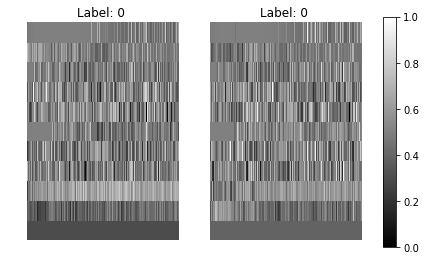

In [7]:
index = 23

plt.subplot(1,2,1)

plt.pcolor(allmat[index], cmap='gray')
plt.title("Label: %d " %label[index])
plt.axis('off')
plt.subplot(1,2,2)
p1=plt.pcolor(allmat[index+240], cmap='gray')
plt.title("Label: %d " %label[index+240])
#plt.colorbar()
#plt.axes().set_aspect(maxstep/24)
plt.axis('off')
cax = plt.gcf().add_axes([.95, 0.1, 0.03, 0.8])
plt.gcf().colorbar(p1, cax=cax)


Next we create data iterators. The data iterator, which is similar the iterator, returns a batch of data in each next() call. A batch contains several images with its according labels. These images are stored in a 4-D matrix with shape (batch_size, num_channels, width, height). In addition, we often shuffle the images used for training, which accelerates the training progress.

In [326]:
import mxnet as mx

# First, shuffle the data
shuffle = np.random.rand(allmat.shape[0]).argsort()
datarand = np.take(allmat,shuffle,axis=0)
labelrand = np.take(label,shuffle)

ntrain = int(allmat.shape[0]*0.8)
train_features = datarand[:ntrain, :]
train_labels = labelrand[:ntrain]
test_features = datarand[ntrain:, :]
test_labels = labelrand[ntrain:]

def to4d(img):
    if(len(img.shape) == 3):
        return img.reshape(img.shape[0], 1, img.shape[1], img.shape[2]).astype(np.float32)
    else:
        return img.reshape(1, 1, img.shape[0], img.shape[1]).astype(np.float32)

batch_size=100
train_iter = mx.io.NDArrayIter(to4d(train_features),train_labels , batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(test_features),test_labels , batch_size)

## Multilayer Perceptron

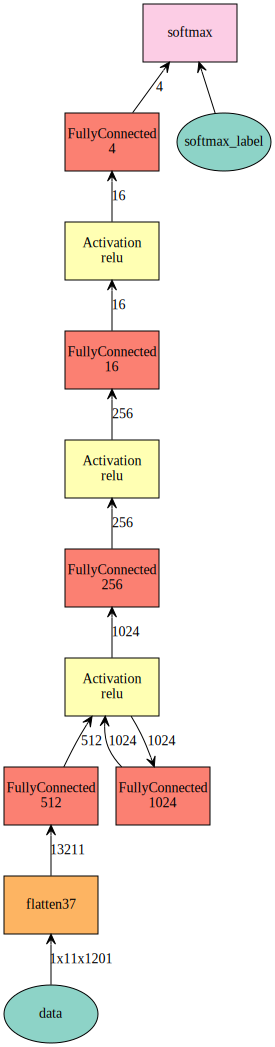

In [332]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)

# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=512)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The first fully-connected layer
fc1a  = mx.sym.FullyConnected(data=act1, name='fc1a', num_hidden=1024)
# Apply relu to the output of the first fully-connnected layer
act1a = mx.sym.Activation(data=fc1a, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1a, name='fc2', num_hidden = 256)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The second fully-connected layer and the according activation function
fc2a  = mx.sym.FullyConnected(data=act2, name='fc2a', num_hidden = 16)
act2a = mx.sym.Activation(data=fc2a, name='relu2a', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2a, name='fc3', num_hidden=len(np.unique(labelrand)))
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, allmat.shape[1], allmat.shape[2])}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [333]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

model = mx.model.FeedForward(
    ctx=mx.gpu(0),
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.2 # learning rate of SGD 
)
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter # validation data
)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
/anaconda/envs/py35/lib/python3.5/site-packages/mxnet-0.9.5-py3.5.egg/mxnet/model.py:516: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [gpu(0)]
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=0.350
INFO:root:Epoch[0] Validation-accuracy=0.412000
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=0.276
INFO:root:Epoch[1] Validation-accuracy=0.412000
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=0.180
INFO:root:Epoch[2] Validation-accuracy=0.412000
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=0.217
INFO:root:Epoch[3] Validation-accuracy=0.412000
INFO:root:Epoch[4] Resetti

Classified as 1 with probability 0.410985
Actual label: 2


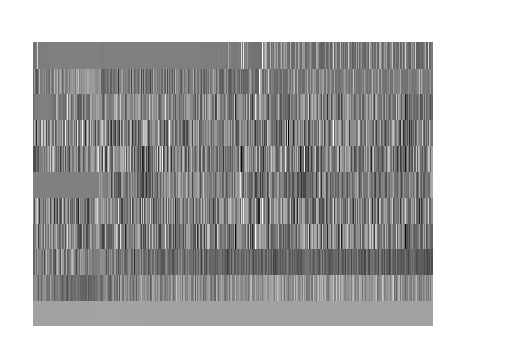

In [329]:
index=np.random.choice(datarand.shape[0])
plt.pcolor(datarand[index], cmap='gray')
plt.axis('off')

prob = model.predict(to4d(datarand[index]))[0]
#assert max(prob) > 0.99, "Low prediction accuracy."
print ('Classified as %d with probability %f' % (prob.argmax(), max(prob)))
print('Actual label: %d' % labelrand[index])



Accuracy Score: 0.4125


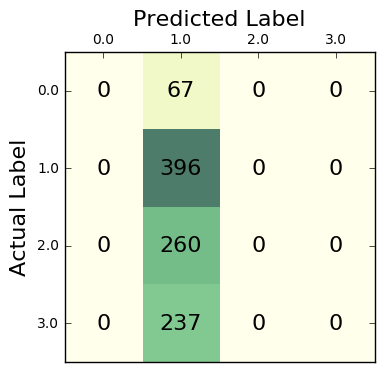

In [334]:
from sklearn.metrics import confusion_matrix


prob = model.predict(to4d(test_features))

y_pred = np.argmax(prob,axis=1)

def show_confusion_matrix(cnf_matrix, class_labels):
    plt.matshow(cnf_matrix,cmap=plt.cm.YlGn,alpha=0.7)
    ax = plt.gca()
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks(range(0,len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_ylabel('Actual Label', fontsize=16, rotation=90)
    ax.set_yticks(range(0,len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    for row in range(len(cnf_matrix)):
        for col in range(len(cnf_matrix[row])):
            ax.text(col, row, cnf_matrix[row][col], va='center', ha='center', fontsize=16)


cnf_matrix = confusion_matrix(test_labels, y_pred)
show_confusion_matrix(cnf_matrix,np.unique(labelrand))
acc_score = metrics.accuracy_score(test_labels, y_pred)

print("Accuracy Score: {}".format(acc_score))